## GRU Network Predictions

In [1]:
##create the classes and prepare the data
import os, sys

sys.path.append(os.path.abspath("../data_set_generator"))
sys.path.append(os.path.abspath("../network_training"))
sys.path.append(os.path.abspath("../data_preprocessing"))
sys.path.append(os.path.abspath("../data"))


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import keras
from keras import optimizers
from keras.models import Sequential
from data_set_generator.bike_prediction import DataGenerator
from data_set_generator.data_config import BikeDataConfig
from network_training.network_generator import NetworkGenerator
from network_training.callbacks import Callbacks

classes = 8
conf = BikeDataConfig(bikes_path = './/../data//bikes.csv', weather_path = './/../data//weather.csv', highest_class = classes)
FFN_logs_base_dir='./Modellcheckpoints/Gru/'
os.makedirs(FFN_logs_base_dir, exist_ok=True)
FFN_log_dir=os.path.join(FFN_logs_base_dir, '_GRU.h5')
callbacks = Callbacks(filepath = FFN_log_dir)


batch_size = 256
input_dims = 11
output_dims = classes + 1 
sequence_length = 3
adam_optimizer = optimizers.Adam(learning_rate = 1e-4, beta_1=1- 1e-4, amsgrad = True)
sgd_optimizer = optimizers.SGD(learning_rate = 1e-2,  momentum = 0.9, nesterov = True)

network_gen = NetworkGenerator(data_generator = conf.d_gen, callbacks = callbacks, history_length = sequence_length)

2025-06-23 17:28:47.297010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create Batch Generators

In [2]:
train_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.train_list_x,
                             y_data = network_gen.data_gen.train_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             random = True)

val_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.vali_list_x,
                             y_data = network_gen.data_gen.vali_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

test_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.test_list_x,
                             y_data = network_gen.data_gen.test_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

x_batch, y_batch = next(train_data_generator)
print(x_batch)
print(y_batch)

[[[ 0.77469835  0.54316378  0.         ...  0.         -0.98480775
   -0.17364818]
  [ 0.77469835  0.54316378  0.         ...  0.         -0.98078528
   -0.19509032]
  [ 0.77469835  0.54316378  0.         ...  0.         -0.97629601
   -0.21643961]]

 [[ 0.77468936  0.54317987  0.         ...  1.         -0.69151306
    0.72236396]
  [ 0.77468936  0.54317987  0.         ...  1.         -0.70710678
    0.70710678]
  [ 0.77468936  0.54317987  0.         ...  1.         -0.72236396
    0.69151306]]

 [[ 0.77468837  0.54314303  0.         ...  1.          0.98078528
    0.19509032]
  [ 0.77468837  0.54314303  0.         ...  1.          0.97629601
    0.21643961]
  [ 0.77468837  0.54314303  0.         ...  1.          0.97134207
    0.23768589]]

 ...

 [[ 0.77461529  0.54307175  0.         ...  1.         -0.83146961
    0.55557023]
  [ 0.77461529  0.54307175  0.         ...  1.         -0.84339145
    0.53729961]
  [ 0.77461529  0.54307175  0.         ...  1.         -0.85491187
    0.51

## Define and Generate a GRU Network

In [3]:
gru = Sequential()
gru.add(keras.layers.GRU(input_dims,
                     recurrent_dropout=0.5, 
                     return_sequences=True, 
                     input_shape = ( x_batch.shape[1], x_batch.shape[2] )  )
         )

gru.add(keras.layers.GRU(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      activation = 'relu',
                      return_sequences=True)
          )

gru.add(keras.layers.GRU(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5, 
                      activation = 'relu'
                      )
          )

gru.add(keras.layers.Dense(output_dims, activation = 'softmax'))
gru.summary()

network_gen.register_network(gru)
network_gen.model.compile(optimizer = sgd_optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
results = network_gen.train_network(validation_data = val_data_generator, epochs = 25, train_data = train_data_generator)

/home/flo/python_environments/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 3, 11)          │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 3, 45)          │         7,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 45)             │        12,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,456 (83.81 KB)

 Trainable params: 21,456 (83.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.3862 - loss: 1.6068

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 179s 136ms/step - categorical_accuracy: 0.3864 - loss: 1.6064 - val_categorical_accuracy: 0.8477 - val_loss: 0.5949
Epoch 2/25
1280/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.8297 - loss: 0.6121

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical_accuracy: 0.8297 - loss: 0.6120 - val_categorical_accuracy: 0.8597 - val_loss: 0.5439
Epoch 3/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.8695 - loss: 0.5123

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - categorical_accuracy: 0.8695 - loss: 0.5123 - val_categorical_accuracy: 0.8696 - val_loss: 0.5163
Epoch 4/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.8871 - loss: 0.4658

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical_accuracy: 0.8871 - loss: 0.4658 - val_categorical_accuracy: 0.8826 - val_loss: 0.4966
Epoch 5/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.8957 - loss: 0.4416

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical_accuracy: 0.8957 - loss: 0.4416 - val_categorical_accuracy: 0.8844 - val_loss: 0.4853
Epoch 6/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.9038 - loss: 0.4269

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - categorical_accuracy: 0.9038 - loss: 0.4269 - val_categorical_accuracy: 0.8857 - val_loss: 0.4777
Epoch 7/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9076 - loss: 0.4101

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical_accuracy: 0.9076 - loss: 0.4101 - val_categorical_accuracy: 0.8856 - val_loss: 0.4715
Epoch 8/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9104 - loss: 0.3968

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9104 - loss: 0.3968 - val_categorical_accuracy: 0.8859 - val_loss: 0.4692
Epoch 9/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9104 - loss: 0.3961

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9104 - loss: 0.3961 - val_categorical_accuracy: 0.8863 - val_loss: 0.4639
Epoch 10/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9143 - loss: 0.3815

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9143 - loss: 0.3815 - val_categorical_accuracy: 0.8857 - val_loss: 0.4559
Epoch 11/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - categorical_accuracy: 0.9152 - loss: 0.3751 - val_categorical_accuracy: 0.8869 - val_loss: 0.4622
Epoch 12/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - categorical_accuracy: 0.9165 - loss: 0.3700 - val_categorical_accuracy: 0.8862 - val_loss: 0.4622
Epoch 13/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9176 - loss: 0.3652

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9176 - loss: 0.3652 - val_categorical_accuracy: 0.8871 - val_loss: 0.4553
Epoch 14/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9169 - loss: 0.3670

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9169 - loss: 0.3670 - val_categorical_accuracy: 0.8868 - val_loss: 0.4524
Epoch 15/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9192 - loss: 0.3606

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9192 - loss: 0.3606 - val_categorical_accuracy: 0.8863 - val_loss: 0.4510
Epoch 16/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9188 - loss: 0.3597

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9188 - loss: 0.3597 - val_categorical_accuracy: 0.8875 - val_loss: 0.4506
Epoch 17/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 39ms/step - categorical_accuracy: 0.9196 - loss: 0.3577 - val_categorical_accuracy: 0.8870 - val_loss: 0.4510
Epoch 18/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9210 - loss: 0.3520

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical_accuracy: 0.9210 - loss: 0.3520 - val_categorical_accuracy: 0.8870 - val_loss: 0.4497
Epoch 19/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical_accuracy: 0.9197 - loss: 0.3556 - val_categorical_accuracy: 0.8875 - val_loss: 0.4507
Epoch 20/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9204 - loss: 0.3526 - val_categorical_accuracy: 0.8873 - val_loss: 0.4514
Epoch 21/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - categorical_accuracy: 0.9217 - loss: 0.3489 - val_categorical_accuracy: 0.8876 - val_loss: 0.4505
Epoch 22/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - categorical_accuracy: 0.9210 - loss: 0.3522 - val_categorical_accuracy: 0.8856 - val_loss: 0.4513
Epoch 23/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - categorical_accuracy: 0.9211 - loss: 0.3487 - val_categorical_accuracy: 0.8873 - val_loss: 0.4521
Epoch 24/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - categorical

## Print Training Results

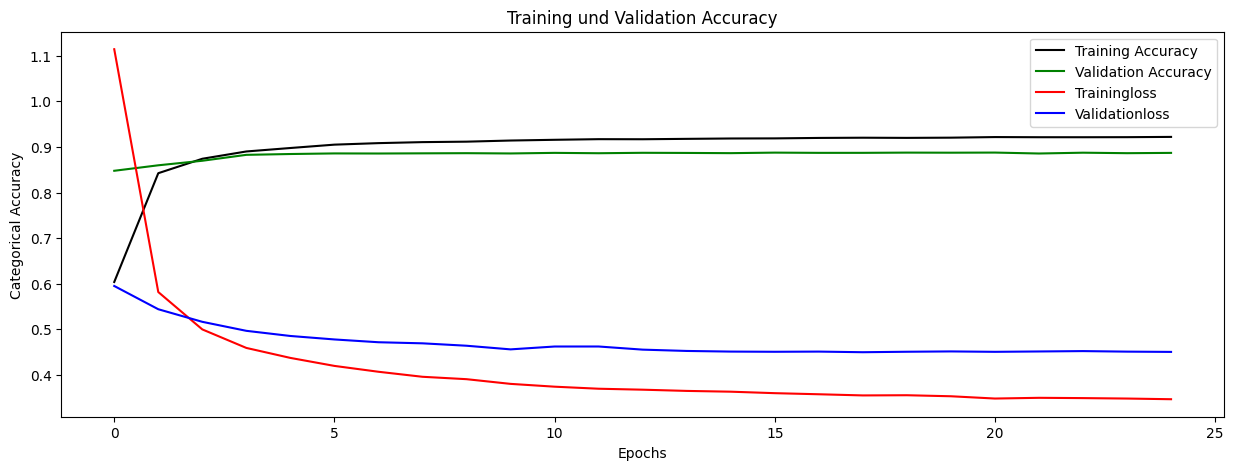

In [4]:
network_gen.print_training(results)

## Test Network and Create Metrics

In [5]:
x_batch, y_batch = next(test_data_generator)
network_gen.test_predictions(network_gen.model, x_batch, y_batch, True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 3, 11)          │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 3, 45)          │         7,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 45)             │        12,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,914 (167.64 KB)

 Trainable params: 21,456 (83.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,458 (83.82 KB)

17595/17595 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - categorical_accuracy: 0.8993 - loss: 0.4130
17595/17595 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
Confusion Matrix
[[ 84127   3559    514     99     27      9      4      1      3]
 [  3534  68082   3476    538     94     21     10      2      0]
 [   421   3382  55608   3244    486     79     18      6      4]
 [   105    487   3111  47309   2696    463     95     35     32]
 [    56    101    361   2618  39422   2614    404     82     80]
 [    18     52     83    374   2488  30431   3056    386    156]
 [    28     33     56    109    372   2222  25629   1972    504]
 [     6      9     16     33     65    292   2095  24642   2124]
 [    38     49     29     38     40     95    429   2185 135444]]
Klassifikations Report
0.9070667493166281
Akkuratheit der Klassifikation
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     88343
           1       0.90      0.90      0.90     75757
           2  